<a href="https://colab.research.google.com/github/firekind/asl-model/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting stuff

In [ ]:
%%shell
pip install --upgrade git+http://github.com/firekind/athena &> /dev/null
echo "Downloaded dependencies."

if [[ ! -d asl-model ]]; then
    git clone https://github.com/firekind/asl-model &> /dev/null
    echo "Cloned repo."
fi

Downloaded dependencies.
Cloned repo.


## Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extracting dataset

In [ ]:
%%shell
DATA_DIR=/content/data
if [[ ! -d $DATA_DIR ]]; then
    mkdir $DATA_DIR
    echo "extracting dataset..."
    tar -xf "/content/drive/My Drive/asl-model/asl-alphabet.tar.xz" -C $DATA_DIR
    echo "done."
else
    echo "dataset already extracted."
fi

extracting dataset...
done.


## Basic config

In [ ]:
import os
os.chdir("/content/asl-model")
dataset_path = "/content/data"
log_path = "/content/drive/My Drive/asl-model/logs"

In [ ]:
from dataset import ASLSignLanguage
from athena.datasets import train_val_split
from athena import Experiments, ClassificationSolver
from athena.models import ResNet18
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
dataset = ASLSignLanguage(dataset_path, use_default_transforms=True)
train_loader, val_loader = train_val_split(dataset, 64, val_split=0.2, use_default_val_transform=True)

In [ ]:
exps = (
    Experiments.builder()
    .name("Sign Language")
    .log_directory(log_path)
    .add("ResNet-18")
        .props()
            .force_restart()
            .monitor("validation accuracy")
            .save_top_k(3)
        .data()
            .train_loader(train_loader)
            .val_loader(val_loader)
        .solver(ClassificationSolver)
            .epochs(10)
            .model(ResNet18(num_classes=29))
            .optimizer(optim.SGD, lr=1e-4, momentum=0.9)
        .build()
    .build()
)

## Range tests

Running LR Finder:
1000/1000 [==============================] - 226s 226ms/step


(0.45149677720361003, 1.2885762131855176)

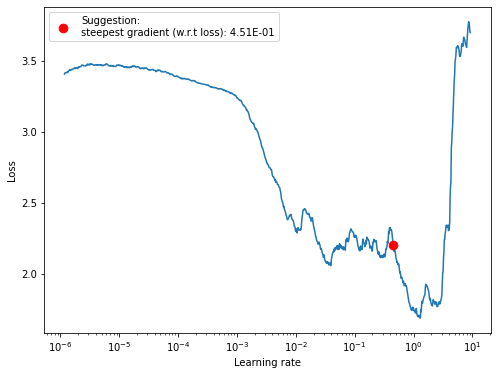

In [ ]:
exps[0].lr_range_test(F.cross_entropy, start_lr=1e-6, end_lr=10, num_iter=1000, step_mode="exp")

Running LR Finder:
2000/2000 [==============================] - 451s 225ms/step


(7.851406690944124, 0.8413224565441154)

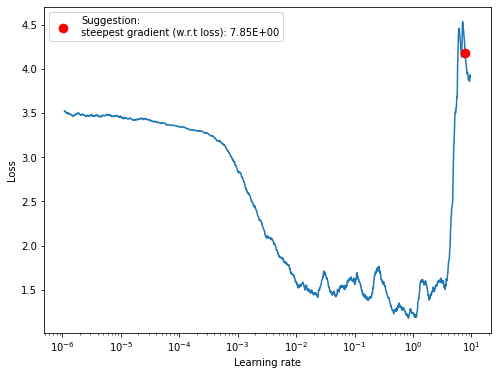

In [ ]:
exps[0].lr_range_test(F.cross_entropy, start_lr=1e-6, end_lr=10, num_iter=2000, step_mode="exp")

Running LR Finder:
 649/1000 [==================>...........] - ETA: 3:46:08
Stopping early, the loss has diverged


(0.03100926635931926, 0.003746050032748995)

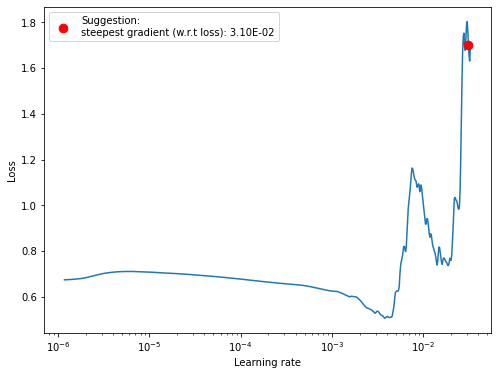

In [ ]:
exps[0].lr_range_test(F.cross_entropy, validate=True, start_lr=1e-6, end_lr=10, num_iter=1000, step_mode="exp")

In [ ]:
exps[0].fit_one_cycle(max_lr=3.7e-3, max_at_epoch=5)

=> Running experiment: ResNet-18
Epoch: 1 / 10
1088/1088 [==============================] - 288s 265ms/step - loss: 0.1180 - train accuracy: 0.7153
Validation set: validation loss: 0.1355, validation accuracy: 0.9731

Epoch: 2 / 10
1088/1088 [==============================] - 301s 277ms/step - loss: 0.0310 - train accuracy: 0.9886
Validation set: validation loss: 0.0474, validation accuracy: 0.9871

Epoch: 3 / 10
1088/1088 [==============================] - 300s 276ms/step - loss: 0.0090 - train accuracy: 0.9967
Validation set: validation loss: 0.0103, validation accuracy: 0.9983

Epoch: 4 / 10
1088/1088 [==============================] - 299s 275ms/step - loss: 0.0060 - train accuracy: 0.9976
Validation set: validation loss: 0.0437, validation accuracy: 0.9834

Epoch: 5 / 10
1088/1088 [==============================] - 299s 275ms/step - loss: 0.0090 - train accuracy: 0.9993
Validation set: validation loss: 0.0102, validation accuracy: 0.9973

Epoch: 6 / 10
1088/1088 [=================

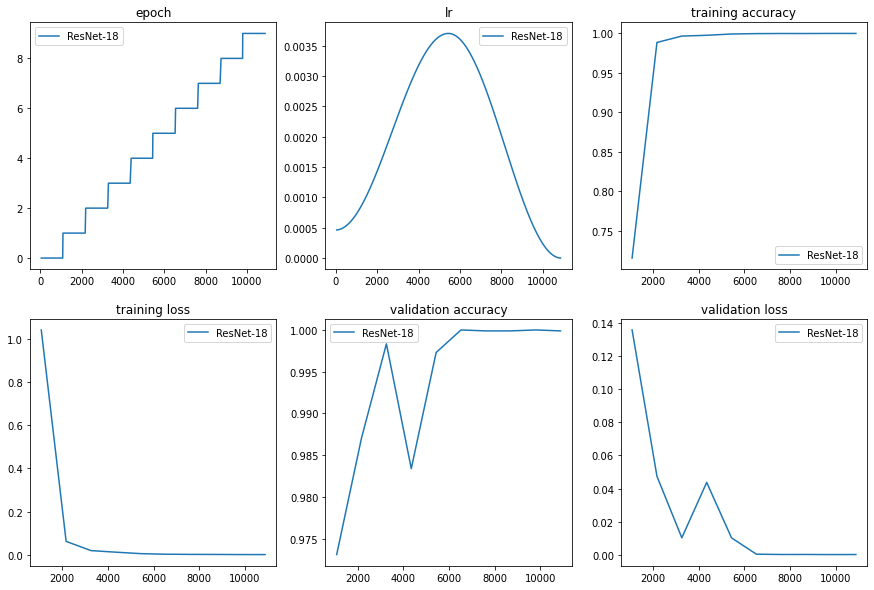

In [ ]:
exps[0].plot_scalars()